<a href="https://colab.research.google.com/github/electrolizzys/Facial_Recognition/blob/main/Residual_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install wandb
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lizikutateladze","key":"5204a8bec832737cfd25ecd92068b1b4"}'}

In [3]:
!pip install -q kaggle

In [4]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 98% 280M/285M [00:00<00:00, 402MB/s]
100% 285M/285M [00:00<00:00, 411MB/s]


In [6]:
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d data/

In [7]:
!ls data

example_submission.csv	fer2013.tar.gz	icml_face_data.csv  test.csv  train.csv


In [8]:
!pip install -q wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lkuta22 (lkuta22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
import pandas as pd


In [10]:
train_df_t = pd.read_csv('/content/data/icml_face_data.csv')

In [11]:
train_df_t.shape

(35887, 3)

In [12]:

train_df = train_df_t[train_df_t[' Usage'] == 'Training']
val_df= train_df_t[train_df_t[' Usage'] == 'PrivateTest']
test_df = train_df_t[train_df_t[' Usage'] == 'PublicTest']

In [13]:
train_df.shape

(28709, 3)

In [14]:
val_df.shape

(3589, 3)

In [15]:
test_df.shape

(3589, 3)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm.notebook import tqdm
import wandb

In [19]:
train_df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


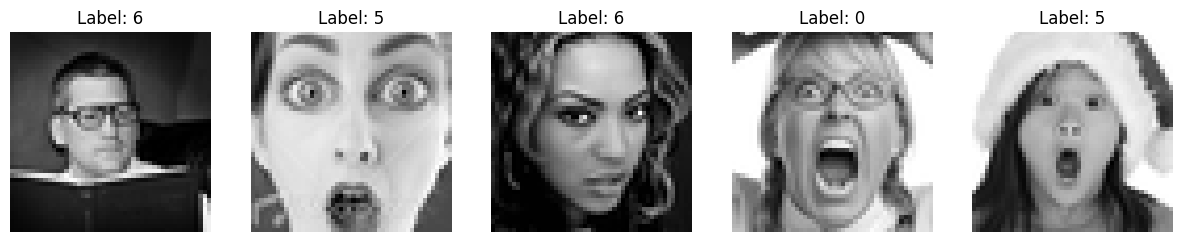

In [21]:

import matplotlib.pyplot as plt
import wandb

class FacialExpressionDataset(Dataset):
    """Custom Dataset for loading facial expression images"""

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pixels = self.df.iloc[idx][' pixels']
        emotion = self.df.iloc[idx]['emotion']

        pixels = np.array(pixels.split(), dtype='uint8')
        pixels = pixels.reshape(48, 48)

        image = Image.fromarray(pixels)

        if self.transform:
            image = self.transform(image)

        return image, emotion

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = FacialExpressionDataset(train_df, transform=data_transforms)
val_dataset = FacialExpressionDataset(val_df, transform=data_transforms)
test_dataset = FacialExpressionDataset(test_df, transform=data_transforms)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def show_sample_images(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img = images[i].numpy().squeeze()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    plt.show()

show_sample_images(train_loader)

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class FacialExpressionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(FacialExpressionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)

        self.residual1 = nn.Conv2d(64, 128, kernel_size=1, stride=2)
        self.residual2 = nn.Conv2d(128, 256, kernel_size=1, stride=2)

    def forward(self, x):
        x1_out = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x1_out, 2)

        x2_out = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x2_out, 2)

        x = x + self.residual1(x1_out)[:, :, ::2, ::2]

        x3_out = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x3_out, 2)

        x = x + self.residual2(x2_out)[:, :, ::2, ::2]

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

num_classes = 7
model = FacialExpressionCNN(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model instantiated and moved to device: {device}")
print(model)


Model instantiated and moved to device: cuda
FacialExpressionCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.3, inplace

In [43]:
model = FacialExpressionCNN(num_classes=7).to(device)


In [44]:
wandb.init(project="facial-expression-recognition", entity=None)

config = wandb.config
config.batch_size = batch_size
config.learning_rate = 0.001
config.epochs = 30
config.model_name = "FacialExpressionCNN"
config.optimizer = "Adam"
config.dropout = 0.5

wandb.watch(model)

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_accuracy,▁▄▄▄▅▆▆▆▇▇▇▇█
train_loss,█▆▅▅▄▃▃▃▂▂▂▂▁
val_accuracy,▃▆▄▃▇▇█▅▅▆▁▆▆
val_loss,▂▄▅▃▃▄▂▆▃▁█▃▄
epoch,12
train_accuracy,96.27643
train_loss,0.1196
val_accuracy,58.6793
val_loss,2.13397


In [26]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        # Print
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Log metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

        #best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            wandb.save('best_model.pth')

    print(f'Finished Training. Best Val Accuracy: {best_val_accuracy:.2f}%')
    return model

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return loss, accuracy

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)



In [46]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, config.epochs)

Epoch 1/30: Train Loss: 1.6623, Train Acc: 32.82%, Val Loss: 1.5516, Val Acc: 41.04%
Epoch 2/30: Train Loss: 1.4103, Train Acc: 45.32%, Val Loss: 1.3144, Val Acc: 49.43%
Epoch 3/30: Train Loss: 1.3002, Train Acc: 49.64%, Val Loss: 1.3363, Val Acc: 48.12%
Epoch 4/30: Train Loss: 1.2190, Train Acc: 53.21%, Val Loss: 1.2228, Val Acc: 53.19%
Epoch 5/30: Train Loss: 1.1455, Train Acc: 56.35%, Val Loss: 1.2856, Val Acc: 51.32%
Epoch 6/30: Train Loss: 1.0798, Train Acc: 58.56%, Val Loss: 1.1646, Val Acc: 54.47%
Epoch 7/30: Train Loss: 1.0061, Train Acc: 61.77%, Val Loss: 1.2844, Val Acc: 53.83%
Epoch 8/30: Train Loss: 0.9325, Train Acc: 64.69%, Val Loss: 1.2590, Val Acc: 53.89%
Epoch 9/30: Train Loss: 0.8604, Train Acc: 67.67%, Val Loss: 1.1545, Val Acc: 58.34%
Epoch 10/30: Train Loss: 0.7850, Train Acc: 70.55%, Val Loss: 1.2978, Val Acc: 55.36%
Epoch 11/30: Train Loss: 0.7011, Train Acc: 73.90%, Val Loss: 1.2990, Val Acc: 56.45%
Epoch 12/30: Train Loss: 0.6361, Train Acc: 76.46%, Val Loss: 1

Test Accuracy: 57.95%


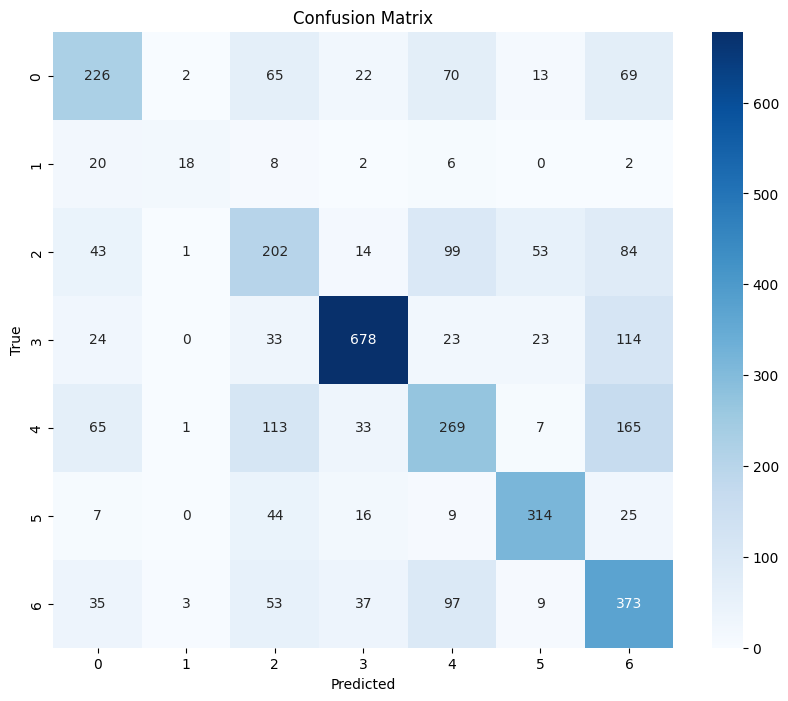

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
train_accuracy,▁▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇██████████
train_loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▆▅▆▆▆▇▆▇▆▆▆█▇▇█▇▇▇▇██▇██▇▇█
val_loss,▄▂▂▁▂▁▂▂▁▂▂▃▅▅▃▄▄▅▆▆▆▇▇▆█▆█▇█▇
epoch,29
test_accuracy,57.95486
train_accuracy,95.63203
train_loss,0.13687
val_accuracy,59.73809


In [47]:
model.load_state_dict(torch.load('best_model.pth'))

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy:.2f}%')

wandb.log({"test_accuracy": test_accuracy})

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
        preds=all_preds,
        y_true=all_labels,
        class_names=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    )})

plot_confusion_matrix(test_loader)

wandb.finish()

In [48]:
torch.save(model, 'facial_expression_model.pth')
from google.colab import drive
drive.mount('/content/drive')

!cp facial_expression_model.pth /content/drive/MyDrive/
!cp best_model.pth /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class EnhancedFacialExpressionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EnhancedFacialExpressionCNN, self).__init__()

        # Enhanced convolutional blocks with residual connections
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        # Enhanced classifier with more capacity
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

num_classes = 7
model = EnhancedFacialExpressionCNN(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Enhanced model instantiated and moved to device: {device}")
print(model)

Enhanced model instantiated and moved to device: cuda
EnhancedFacialExpressionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

Epoch 1/40: Train Loss: 1.5693, Train Acc: 37.37%, Val Loss: 1.4165, Val Acc: 46.67%
Epoch 2/40: Train Loss: 1.2529, Train Acc: 52.08%, Val Loss: 1.2126, Val Acc: 53.33%
Epoch 3/40: Train Loss: 1.1303, Train Acc: 57.14%, Val Loss: 1.1332, Val Acc: 57.04%
Epoch 4/40: Train Loss: 1.0429, Train Acc: 60.91%, Val Loss: 1.0492, Val Acc: 59.63%
Epoch 5/40: Train Loss: 0.9628, Train Acc: 63.80%, Val Loss: 1.0216, Val Acc: 61.27%
Epoch 6/40: Train Loss: 0.8841, Train Acc: 67.24%, Val Loss: 1.2036, Val Acc: 57.06%
Epoch 7/40: Train Loss: 0.8053, Train Acc: 70.43%, Val Loss: 1.0122, Val Acc: 61.97%
Epoch 8/40: Train Loss: 0.7159, Train Acc: 74.12%, Val Loss: 1.0859, Val Acc: 61.91%
Epoch 9/40: Train Loss: 0.6179, Train Acc: 77.41%, Val Loss: 1.0998, Val Acc: 61.47%
Epoch 10/40: Train Loss: 0.5162, Train Acc: 81.79%, Val Loss: 1.3510, Val Acc: 59.93%
Epoch 11/40: Train Loss: 0.4248, Train Acc: 85.15%, Val Loss: 1.1655, Val Acc: 63.36%
Epoch 12/40: Train Loss: 0.3402, Train Acc: 88.28%, Val Loss: 1

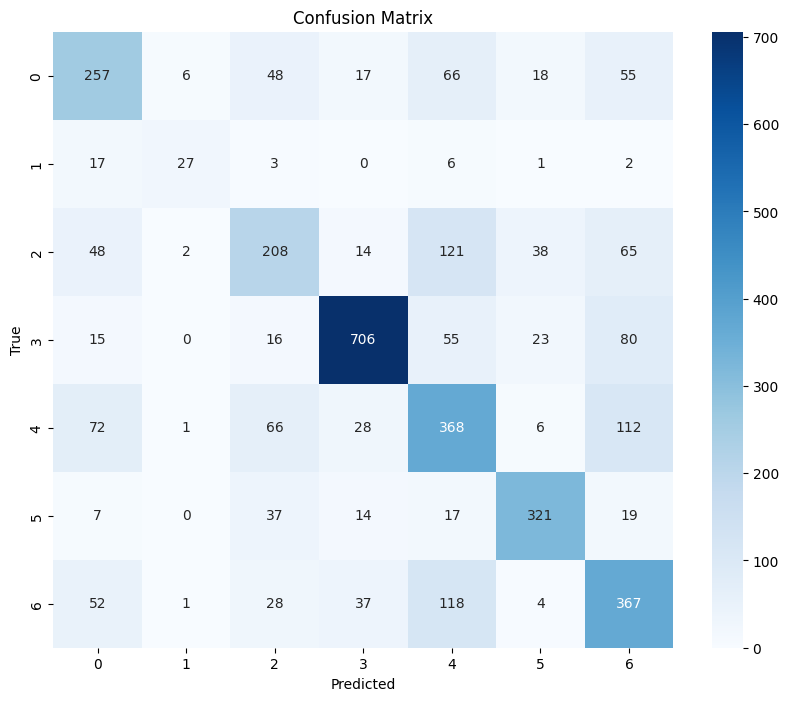

enhanced_test_accuracy,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▃▃▄▄▄▅▅▆▆▆▇▇▇▇█████████████████████████
train_loss,█▇▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▅▇▇▇▆█▇▆▇▆▇▇▇█▇▇██▇▇▇██▇█▇▇▇██▇████
val_loss,▃▂▂▁▁▂▁▁▁▃▂▃▄▄▅▄▄▅▅▆▆▅▅▅▇█▅▆▆▆▆▇▇▇▆▇▇▆▇▇
enhanced_test_accuracy,62.80301
epoch,39
train_accuracy,98.13996
train_loss,0.0561
val_accuracy,63.3324


Mounted at /content/drive


In [55]:

wandb.init(project="facial-expression-recognition-enhanced", entity=None)

config = wandb.config
config.batch_size = batch_size
config.learning_rate = 0.001
config.epochs = 40
config.model_name = "EnhancedFacialExpressionCNN"
config.optimizer = "Adam"
config.dropout = 0.5

wandb.watch(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

enhanced_model = train_model(model, train_loader, val_loader, criterion, optimizer, config.epochs)

enhanced_model.load_state_dict(torch.load('best_model.pth'))

test_loss_enhanced, test_accuracy_enhanced = evaluate_model(enhanced_model, test_loader, criterion)
print(f'Enhanced Model Test Accuracy: {test_accuracy_enhanced:.2f}%')

wandb.log({"enhanced_test_accuracy": test_accuracy_enhanced})

plot_confusion_matrix(test_loader)

wandb.finish()

torch.save(enhanced_model, 'enhanced_facial_expression_model.pth')

drive.mount('/content/drive', force_remount=True)
!cp enhanced_facial_expression_model.pth /content/drive/MyDrive/
!cp best_model.pth /content/drive/MyDrive/enhanced_best_model.pth

In [28]:

import torch.nn.functional as F

class ResidualAttentionModel(nn.Module):
    def __init__(self, num_classes=7):
        super(ResidualAttentionModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.ra_block1 = ResidualAttentionBlock(64, 128, stride=2)
        self.ra_block2 = ResidualAttentionBlock(128, 256, stride=2)
        self.ra_block3 = ResidualAttentionBlock(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ra_block1(x)
        x = self.ra_block2(x)
        x = self.ra_block3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ResidualAttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels//8, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels//8, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        attention = self.attention(x)
        x = x * attention

        x += residual
        return F.relu(x)

In [30]:
import numpy as np
num_classes = 7
model = ResidualAttentionModel(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Residual Attention Model instantiated and moved to device: {device}")
print(model)

wandb.init(project="facial-expression-recognition-attention", entity=None)

config = wandb.config
config.batch_size = batch_size
config.learning_rate = 0.001
config.epochs = 35
config.model_name = "ResidualAttentionModel"
config.optimizer = "Adam"

wandb.watch(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

attention_model = train_model(model, train_loader, val_loader, criterion, optimizer, config.epochs)

attention_model.load_state_dict(torch.load('best_model.pth'))

test_loss_attention, test_accuracy_attention = evaluate_model(attention_model, test_loader, criterion)
print(f'Residual Attention Model Test Accuracy: {test_accuracy_attention:.2f}%')

wandb.log({"attention_test_accuracy": test_accuracy_attention})


wandb.finish()

torch.save(attention_model, 'residual_attention_model.pth')

drive.mount('/content/drive', force_remount=True)
!cp residual_attention_model.pth /content/drive/MyDrive/
!cp best_model.pth /content/drive/MyDrive/residual_attention_best_model.pth

Residual Attention Model instantiated and moved to device: cuda
ResidualAttentionModel(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (ra_block1): ResidualAttentionBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (attention): Sequential(
      (0): AdaptiveAvgPool2d(output_size=1)
      (1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 128

attention_test_accuracy,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▂▃▄▄▅▆▇▇▇█████████████████████████
train_loss,█▇▆▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇▇▇▆█▇▇█▆▇█▆▇███▇▇▇▇▇█▇▇▇▇▇▇█
val_loss,▁▁▁▁▁▂▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇██▇█▇█▇█
attention_test_accuracy,56.06018
epoch,34
train_accuracy,98.62761
train_loss,0.04268
val_accuracy,56.64531


Epoch 1/35: Train Loss: 1.4892, Train Acc: 41.98%, Val Loss: 1.3568, Val Acc: 47.00%
Epoch 2/35: Train Loss: 1.2634, Train Acc: 51.92%, Val Loss: 1.2853, Val Acc: 49.71%
Epoch 3/35: Train Loss: 1.1208, Train Acc: 57.35%, Val Loss: 1.2145, Val Acc: 54.75%
Epoch 4/35: Train Loss: 0.9696, Train Acc: 63.60%, Val Loss: 1.2856, Val Acc: 54.25%
Epoch 5/35: Train Loss: 0.8060, Train Acc: 69.90%, Val Loss: 1.2943, Val Acc: 55.81%
Epoch 6/35: Train Loss: 0.6305, Train Acc: 76.70%, Val Loss: 1.3699, Val Acc: 55.67%
Epoch 7/35: Train Loss: 0.4684, Train Acc: 82.74%, Val Loss: 1.5318, Val Acc: 56.23%
Epoch 8/35: Train Loss: 0.3344, Train Acc: 88.40%, Val Loss: 1.7848, Val Acc: 53.91%
Epoch 9/35: Train Loss: 0.2415, Train Acc: 91.45%, Val Loss: 1.9098, Val Acc: 54.92%
Epoch 10/35: Train Loss: 0.1948, Train Acc: 93.37%, Val Loss: 2.1010, Val Acc: 56.39%
Epoch 11/35: Train Loss: 0.1503, Train Acc: 94.93%, Val Loss: 2.2148, Val Acc: 56.42%
Epoch 12/35: Train Loss: 0.1369, Train Acc: 95.49%, Val Loss: 2

attention_test_accuracy,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▂▃▄▄▅▆▇▇▇█████████████████████████
train_loss,█▇▆▅▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▆▇▇▇▆▆▇▇▇▇█▇▆▇▇▇▇█▇▇▇███▆▇▇▇▇██▇
val_loss,▁▁▁▁▁▂▂▃▃▄▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█
attention_test_accuracy,55.61438
epoch,34
train_accuracy,98.52311
train_loss,0.04355
val_accuracy,55.50293


NameError: name 'drive' is not defined